# NLP -  BoW, TF-IDF, Word2Vec, GloVE, CYK
## By: Idan Dunsky and Yaniv Kaveh Shtul


In [ ]:
import nltk
import requests
import re
import pandas as pd
import numpy as np
import itertools
from scipy import sparse
from collections import defaultdict

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

file_encoding = 'latin-1'


[nltk_data] Downloading package punkt to /home/id/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/id/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/id/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Scraping wikipedia
web scraping the text from wikipedia page of NLP in order to use it as our corpus.

In [ ]:
# Specify the URL of the Wikipedia page
url = 'https://en.wikipedia.org/wiki/Natural_language_processing'

# Send a GET request to fetch the raw HTML content
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the main content text
    # Wikipedia's main content is typically within <div> tags with the 'mw-parser-output' class
    content_div = soup.find('div', class_='mw-parser-output')

    # Initialize an empty list to hold all text content
    all_text = []

    # Extract text from various elements
    for element in content_div.find_all(['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li', 'blockquote']):
        all_text.append(element.get_text())

    # Combine all text into a single string
    corpus = '\n'.join(all_text)

### Tokenization
we will perform tokenization on the corpus and leave stop words out.

In [ ]:
# helper function
def nltk_tok(l):
    all_words_nltk = []
    for text in l:
        all_words_nltk.extend(word_tokenize(text))

    return [token.lower() for token in all_words_nltk if token.lower() not in stop_words and token.isalpha()]

In [ ]:
tokenized_words = nltk_tok(corpus.split('\n'))
print(f'We\'ve got {len(tokenized_words)} Tokenized words:\n {tokenized_words}')

We've got 2614 Tokenized words:
 ['natural', 'language', 'processing', 'nlp', 'interdisciplinary', 'subfield', 'computer', 'science', 'artificial', 'intelligence', 'primarily', 'concerned', 'providing', 'computers', 'ability', 'process', 'data', 'encoded', 'natural', 'language', 'thus', 'closely', 'related', 'information', 'retrieval', 'knowledge', 'representation', 'computational', 'linguistics', 'subfield', 'linguistics', 'typically', 'data', 'collected', 'text', 'corpora', 'using', 'either', 'statistical', 'approaches', 'machine', 'learning', 'deep', 'learning', 'major', 'tasks', 'natural', 'language', 'processing', 'speech', 'recognition', 'text', 'classification', 'understanding', 'generation', 'history', 'edit', 'natural', 'language', 'processing', 'roots', 'already', 'alan', 'turing', 'published', 'article', 'titled', 'computing', 'machinery', 'intelligence', 'proposed', 'called', 'turing', 'test', 'criterion', 'intelligence', 'though', 'time', 'articulated', 'problem', 'separat

### Lemmatization
we will perform lemmatization on the tokenized words

In [ ]:
# helper function
def lem_nltk(l):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in l]

In [ ]:
lemmatized_tokens = set(lem_nltk(tokenized_words))
print(f'we got {len(lemmatized_tokens )} lemmatized words:\n{lemmatized_tokens}')

we got 1224 lemmatized words:
{'parsing', 'segmentation', 'question', 'author', 'ijcai', 'twenty', 'assign', 'supervised', 'kumaran', 'increasing', 'entity', 'possible', 'journal', 'translation', 'costly', 'czech', 'december', 'induction', 'luisa', 'art', 'privacy', 'sue', 'intelligence', 'handbook', 'lessening', 'day', 'subfield', 'universal', 'operational', 'branch', 'chinese', 'case', 'flurry', 'block', 'occur', 'calculus', 'manjot', 'stress', 'duan', 'version', 'criterion', 'example', 'external', 'goal', 'featuring', 'berlin', 'college', 'named', 'best', 'essay', 'head', 'assistive', 'quality', 'national', 'obsolete', 'reveals', 'mit', 'take', 'human', 'chatbot', 'simple', 'robinson', 'hall', 'ngram', 'maint', 'startlingly', 'automated', 'lesk', 'including', 'dbpedia', 'beyond', 'august', 'ny', 'chan', 'framenet', 'compound', 'existence', 'spacy', 'medicine', 'machinery', 'comprehension', 'interface', 'inferior', 'symbol', 'al', 'omitted', 'various', 'advance', 'cognition', 'techni

### Statistics checkpoint

In [ ]:
from collections import Counter

# helper function
def most_freq(l):
        word_freq = Counter(l)
        most_common_words = word_freq.most_common(5)
        return most_common_words

In [ ]:
print(f'\nThere are {len(tokenized_words)} words in our tokens list')

print("Most 5 common words: \n")

for i, word in enumerate(most_freq(tokenized_words)):
    print(f'{i+1}. "{word[0]}", count: {word[1]}')




There are 2614 words in our tokens list
Most 5 common words: 

1. "language", count: 75
2. "natural", count: 44
3. "processing", count: 41
4. "nlp", count: 31
5. "linguistics", count: 28


## BoW
now we will use Bag Of Words algorithm on the text, we will first preprocess it differently.

In [ ]:
# preproccess for BoW
def preprocessing_text(text):
    lemmatizer = WordNetLemmatizer()

    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text= re.sub(r'\s+', ' ', text)
    text= text.lower().strip()

    return text

In [ ]:
# tokenizing sentences
sentences_list = nltk.sent_tokenize(corpus)

# make a list of processed sentences
proc_corpus = [preprocessing_text(sentence) for sentence in sentences_list]

print(proc_corpus)
print(sentences_list)

['natural language processing nlp interdisciplinary subfield computer science artificial intelligence', 'it primarily concerned providing computer ability process data encoded natural language thus closely related information retrieval knowledge representation computational linguistics subfield linguistics', 'typically data collected text corpora using either rulebased statistical neuralbased approach machine learning deep learning', 'major task natural language processing speech recognition text classification naturallanguage understanding naturallanguage generation', 'historyedit natural language processing root s', 'already alan turing published article titled computing machinery intelligence proposed called turing test criterion intelligence though time articulated problem separate artificial intelligence', 'the proposed test includes task involves automated interpretation generation natural language', 'symbolic nlp s early sedit the premise symbolic nlp wellsummarized john searles

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(proc_corpus)

feature_names = vectorizer.get_feature_names_out()

X_array = X.toarray()
print("Bag Of Words:\n")
print("Unique Word List: \n", feature_names)
print("Bag of Words Matrix: \n", X_array)

Bag Of Words:

Unique Word List: 
 ['aaron' 'abelson' 'ability' ... 'zakaria' 'zhu' 'černocký']
Bag of Words Matrix: 
 [[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## TF-IDF
we will use TF-IDF on the processed text.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
vectorized_data = tfidf.fit_transform(proc_corpus)

vals = zip(tfidf.get_feature_names_out(), tfidf.idf_)


print('\ntf-idf values:')
for word, score in vals:
    print(f'{word} : {score}')


tf-idf values:
aaron : 6.22305488204749
abelson : 6.22305488204749
ability : 5.817589773939325
able : 6.22305488204749
above : 6.22305488204749
abstract : 6.22305488204749
academy : 6.22305488204749
accidentally : 6.22305488204749
accuracy : 6.22305488204749
accurate : 5.817589773939325
achieve : 5.817589773939325
acl : 5.3067641501733345
acm : 5.817589773939325
acquiring : 6.22305488204749
acquisition : 6.22305488204749
action : 6.22305488204749
active : 6.22305488204749
actr : 6.22305488204749
addition : 6.22305488204749
additional : 6.22305488204749
addressed : 6.22305488204749
adi : 6.22305488204749
administration : 6.22305488204749
advance : 5.817589773939325
advanced : 6.22305488204749
advances : 6.22305488204749
advantage : 5.817589773939325
age : 6.22305488204749
ai : 4.8367605209276
aicomplete : 6.22305488204749
aid : 5.817589773939325
al : 5.817589773939325
alan : 6.22305488204749
alexander : 6.22305488204749
algorithm : 4.613616969613389
algorithms : 5.529907701487544
align

## Word2Vec
now we will use word2vec algorithm on the tokenized words.

In [ ]:
# gensim is using a deprecated scipy function, in order to use it we will downgrade scipy
#%pip install gensim
#%pip install scipy==1.10.1

from gensim.models.word2vec import Word2Vec

sent_list = [sentence.split() for sentence in sentences_list]


model = Word2Vec(
    sentences=sent_list,      # The corpus to train the model on
    vector_size=100,       # The size of the word vectors to be learned
    window=5,              # The size of the window of words to be considered
    min_count=5,           # The minimum frequency required for a word to be included in the vocabulary
    sg=0,                  # 0 for CBOW, 1 for skip-gram
    negative=5,            # The number of negative samples to use for negative sampling
    ns_exponent=0.75,      # The exponent used to shape the negative sampling distribution
    alpha=0.03,            # The initial learning rate
    min_alpha=0.0007,      # The minimum learning rate to which the learning rate will be linearly reduced
    epochs=30,             # The number of epochs (iterations) over the corpus
    workers=4,             # The number of worker threads to use for training the model
    seed=42,               # The seed for the random number generator
)


In [ ]:
print(f"The vector that represents the word 'Natural' is:\n{model.wv['Natural']}\n")
print(f"The vector that represents the word 'NLP' is:\n{model.wv['NLP']}")

The vector that represents the word 'Natural' is:
[ 0.08230982  0.04255114 -0.03423752  0.08789198 -0.20375429  0.06899934
 -0.09983541  0.25189927 -0.36569828 -0.01480603 -0.2806552   0.29651764
  0.09995639  0.26927078  0.19330406 -0.21255045 -0.04792952 -0.3083904
 -0.10957504 -0.10126338 -0.06673414  0.2300936   0.21441841  0.24066769
  0.17517355  0.04158238 -0.12468346  0.01474531 -0.09025217 -0.06766091
 -0.04420594 -0.05665222 -0.041471   -0.03193695 -0.04857094 -0.08321212
  0.10709751 -0.26628387  0.0581479   0.20266418  0.08827441 -0.02689945
  0.3407842  -0.13207121  0.03194236 -0.00663143  0.09263708  0.20101927
  0.3654548  -0.06965524 -0.03510097 -0.336407   -0.15396182  0.04877256
  0.20312557 -0.13951673  0.10724439  0.08871023 -0.17597784  0.20605092
  0.05765503  0.04373582 -0.10236289  0.0923849   0.14554411  0.00140213
 -0.04538881 -0.21384218 -0.04012749 -0.05742019  0.05239601 -0.16411537
  0.00916763 -0.06675824  0.12473638 -0.1242876   0.10430761 -0.01826609
 -

## GLOVE

GloVe (Global Vectors for Word Representation) is an NLP algorithm developed at Stanford to create word embeddings. It constructs a co-occurrence matrix from a large text corpus, capturing how often words appear together. By optimizing an objective function, GloVe produces word vectors where similar words have similar vectors, effectively capturing semantic relationships. These embeddings are useful for various NLP tasks like text classification and sentiment analysis, combining the strengths of local context methods and global matrix factorization.

In [ ]:
from zeugma.embeddings import EmbeddingTransformer

glove = EmbeddingTransformer('glove')
embeddings = glove.transform(lemmatized_tokens)


let's view the results.

In [ ]:
lemm_list = list(lemmatized_tokens)
for i in range(4):
    print(f'{lemm_list[i]}   --->   {embeddings[i]}\n')

parsing   --->   [ 0.064486  0.67207  -0.16478   0.72935   0.20616  -1.0114   -0.55858
 -1.8942    1.0399   -0.36482  -0.043792  1.0623   -0.044015 -0.89354
  0.6419    0.76916   0.072849  1.0224    1.003    -0.34958  -0.56858
 -0.24884  -0.4645   -0.48293  -1.1382  ]

segmentation   --->   [-4.0351e-01  3.8238e-01 -4.3637e-01 -1.6800e-01  8.5124e-01 -1.0428e+00
 -2.5376e-01 -1.3207e+00  1.0348e+00 -1.0647e+00  2.0543e-01  7.6574e-01
 -3.7057e-01  8.1306e-01  1.1686e+00  1.2766e-03  2.9955e-01  7.9097e-01
  1.1449e+00 -7.9174e-02  8.5297e-01 -8.2245e-01 -3.3126e-01 -8.5536e-01
 -1.2424e+00]

question   --->   [ 1.1137   0.21869 -1.055    0.62141  0.47224 -0.2966   1.5678  -0.6598
  0.20278 -0.15293 -0.13443  0.39467 -3.5114   0.05432  0.64362  0.90003
  0.15945 -0.33852 -1.5233   0.11192  1.1011  -0.28328 -0.3159   0.10382
 -1.064  ]

author   --->   [-0.099235  0.016408  0.21557   0.011018  0.70307  -1.8131    1.0759
  0.095239  0.35433  -1.787     0.14229   1.0552   -2.662    -0.2942

# CYK examples:

### 1st

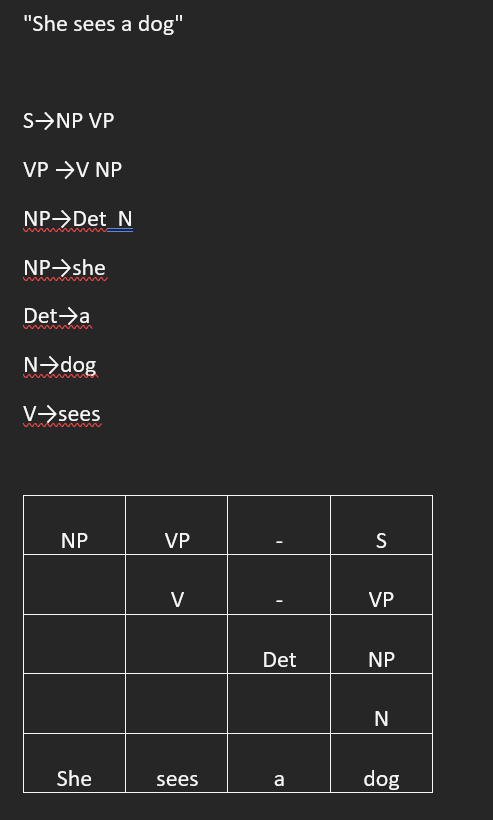

## 2nd

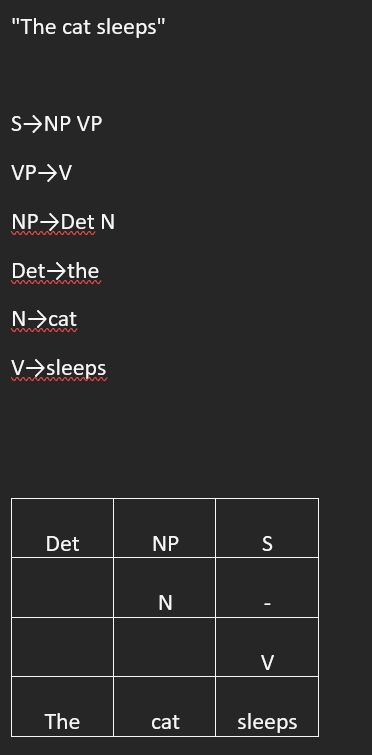

## 3rd

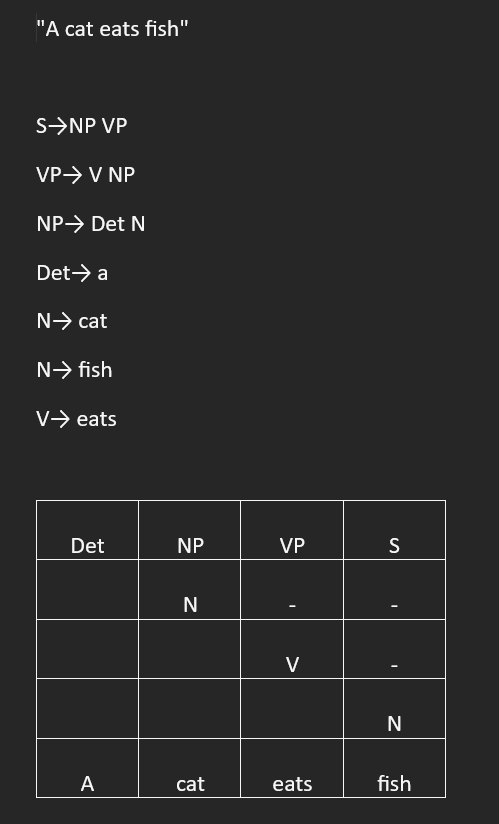

## 4th

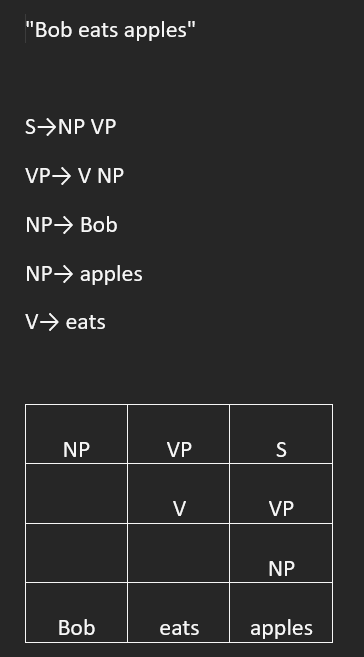

## 5th

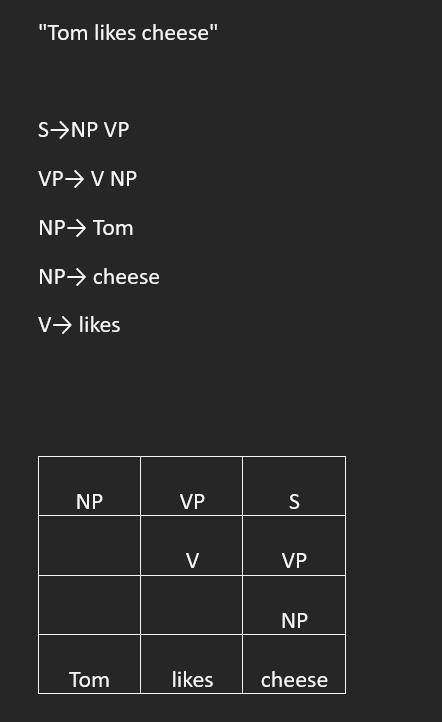